In [50]:
import numpy as np
import pandas as pd
import gurobipy as gp
import math
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ortho_group
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 15 # 全体のフォントサイズ


In [51]:
import LCP_FS   # Facchinei and Soares
import LCP_FW   # Frank-Wolfe
import LCP_FISTA  # Nesterov
import LCP_DCA  # DCA
import LCP_DCAE # DCA Eig
import LCP_DCAT # DCA Tri
import LCP_AVE # DCA AVE

import importlib
importlib.reload(LCP_FS)
importlib.reload(LCP_FW)
importlib.reload(LCP_FISTA)
importlib.reload(LCP_DCA)
importlib.reload(LCP_DCAE)
importlib.reload(LCP_DCAT)
importlib.reload(LCP_AVE)

<module 'LCP_AVE' from 'C:\\Users\\takala\\Documents\\takala-bako\\LCP\\LCP_AVE.py'>

In [52]:
# Make Test Case

def Make_Coffee(N):
    sp = 128
    M = np.diag(np.ones(N)*4) - np.roll(np.eye(N), 1, axis=1) - np.roll(np.eye(N), 1, axis=0)
    M[N-1, 0] = 0
    M[0, N-1] = 0
    b = np.array([math.sin((i+1) * math.pi/sp) for i in range(N)])
    return M, b


def Make_Tea(N, PD=True):  #not symetric
    sp=0.5
    x = np.linspace(0,1,N)
    x_m = np.where(x<(sp), 0.0, x)
    
    if PD:
        D = np.diag(np.random.rand(N)) # positive definite
    else:
        D = np.diag(np.random.rand(N)-0.5) # not positive definite
    
    Q = ortho_group.rvs(dim=N)
    
    M = np.linalg.inv(Q)@D@Q # not symetric
    b = - np.dot(M, x_m) + (x - x_m)
    
    return M, b


def Make_Chai(N, PD=True): #symetric
    sp=0.5
    x = np.linspace(0,1,N)
    x_m = np.where(x<(sp), 0.0, x)
    
    if PD:
        D = np.diag(np.random.rand(N)) # positive definite
    else:
        D = np.diag(np.random.rand(N)-0.5) # not positive definite
    Q = ortho_group.rvs(dim=N)
    
    M = Q.T@D@Q # symetric
    b = - np.dot(M, x_m) + (x - x_m)
    return M,b
    

def Make_LCP6(N):
    M = np.zeros(shape=(N,N))
    for i in range(N):
        for j in range(N):
            n = min(i,j)
            M[i,j] = 4*(n+1)-2
    M = M - np.eye(N)
    b = - np.ones(N)
    return M,b

    
def Make_Lemke(N):
    path = 'Lemke100/'
    M = pd.read_csv(path + 'M.csv', encoding='utf-8-sig', ).values
    b = pd.read_csv(path + 'b.csv', encoding='utf-8-sig', ).values.flatten()
    return M, b

In [53]:
class A9:
    def coef(self, n):
        M = np.eye(n)
        for i in range(n-1):
            M[i, i+1:] = 2
        q = -np.ones(n)
        return M, q
        
    def evaluate(self, x):
        n = x.size
        M, q = self.coef(n)
        ret = np.dot(x, M@x) + q.T@x
        return ret
    
    
class A6:
    def coef(self, n):
        diag = [4 * i - 3 for i in range(1, n + 1)]
        M = np.diag(diag)
        for i in range(n-1):
            M[i, i+1:] = 4 * (i + 1) - 2
        M = np.triu(M) + np.triu(M).T - np.diag(M.diagonal())
        q = -np.ones(n)
        return M, q
    
    def evaluate(self, x):
        n = x.size
        M, q = self.coef(n)
        ret = np.dot(x, M@x) + q.T@x
        return ret
    
class A1:
    def coef(self, n):
        M = np.array([[0, -1, 2], [2, 0, -2], [-1, 1, 0]])
        q = np.array([3, -6, 1])
        return M, q
    
    def evaluate(self, x):
        n = x.size
        M, q = self.coef(n)
        ret = np.dot(x, M@x) + q.T@x
        return ret

        
    def problem_name(self):
        return "LCP1"


In [75]:
N = 500

np.random.seed(10)

# M, b = Make_Coffee(N)

#not symetric
# M, b = Make_Tea(N, PD=False)
# M, b = Make_Tea(N, PD=True)

#symetric
# M, b = Make_Chai(N, PD=False)
M, b = Make_Chai(N, PD=True)


# M, b = Make_LCP6(N)

M, b = A6().coef(N)
# M, b = A1().coef(N)

In [76]:
%%time
# Newton method by Facchinei and Soares
FS_model = LCP_FS.model(M, b)
FS_x, FS_x_list = FS_model.solve(err=10**(-6), max_itr=100, x0=np.ones(N))
# FS_x

CPU times: total: 36 s
Wall time: 9.09 s


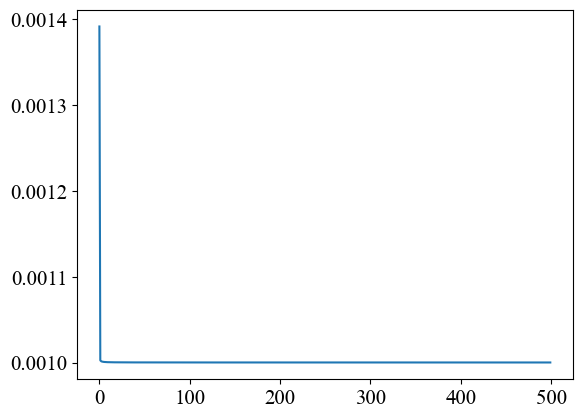

In [77]:
plt.plot(FS_x)

In [79]:
(FS_x.T@M@FS_x) + b@FS_x

166.24311373364057

In [59]:
%%time
# importlib.reload(LCP_FW)
# Frank-wolfe method
FW_model = LCP_FW.model(M, b)
FW_x, FW_x_list = FW_model.solve(err=10**(-6), max_itr=100)
# FW_x

CPU times: total: 13.7 s
Wall time: 2.54 s


In [80]:
%%time
# importlib.reload(LCP_AVE)
# AVE method
AVE_model = LCP_AVE.model(M, b)
AVE_x, AVE_x_list = AVE_model.solve(x0=np.zeros(N), err=10**(-6), max_itr=100)
# AVE_x

CPU times: total: 828 ms
Wall time: 338 ms


In [63]:
%%time
# importlib.reload(LCP_FISTA)
# Nesterov-accelerated-gradient-descent for the merit function (F)
FISTA_F_model = LCP_FISTA.model(M, b)
FISTA_F_x, FISTA_F_x_list = FISTA_F_model.solve_F(err=10**(-6), L=0.001, max_itr=100)
# FISTA_F_x

CPU times: total: 6.97 s
Wall time: 1.84 s


In [64]:
%%time
# importlib.reload(LCP_FISTA)
# Nesterov-accelerated-gradient-descent for the merit function (M)
FISTA_M_model = LCP_FISTA.model(M, b)
FISTA_M_x, FISTA_M_x_list = FISTA_M_model.solve_M(err=10**(-6), L=0.001, max_itr=100)
# FISTA_M_x

Restart
Restart
Restart
Restart
CPU times: total: 5.86 s
Wall time: 1.54 s


In [65]:
%%time
importlib.reload(LCP_DCA)
DCA_model = LCP_DCA.model(M, b)

DCA_x, DCA_x_list = DCA_model.solve(err=10**(-6), max_itr=50)
# DCA_x

1023.6891675418699
424.2661666463137
268.06796098469806
205.06214883571303
169.7524046113395
145.69459399101675
127.0587783042924
111.80142468535418
98.84140723917498
87.60375166397829
77.67486087208543
68.82007129969467
60.90288413790678
53.809273457314276
47.442817278584386
41.73322839066017
36.63467309262534
32.05470910062979
27.959567374893396
24.310728445989113
21.035005735067713
18.088349817463495
15.440278834704188
13.075207346254615
10.965808126218164
9.089063679053027
7.422911688932402
5.9652486853770625
4.703536891631558
3.6230190561721116
2.7172838855281185
1.9782863942674425
1.385879493877269
0.9230928706332548
0.5728070740479723
0.3284967923895721
0.16754222187924483
0.08009751389408848
0.03539165568139424
0.013586479929870166
0.0045586572285714055
0.0016893171708431964
0.0006677717468903666
0.00022864810864575702
8.155110724317183e-05
3.214421359132302e-05
1.2099305962465223e-05
CPU times: total: 2min 33s
Wall time: 34.2 s


In [83]:
%%time
importlib.reload(LCP_DCAE)
DCAE_model = LCP_DCAE.model(M, b)

DCAE_x, DCAE_x_list = DCAE_model.solve(err=10**(-6), max_itr=100)
# DCAE_x, DCAE_x_list = DCAE_model.solve(x0=np.ones(N), err=10**(-6), max_itr=50)
# DCAE_x

0.0
Break-code-1
CPU times: total: 4.48 s
Wall time: 1.25 s


In [85]:
%%time
importlib.reload(LCP_DCAT)
DCAT_model = LCP_DCAT.model(M, b)

DCAT_x, DCAT_x_list = DCAT_model.solve(err=10**(-6), max_itr=100)
# DCAT_x

CPU times: total: 31.2 ms
Wall time: 48.5 ms


In [86]:
DCAT_x

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

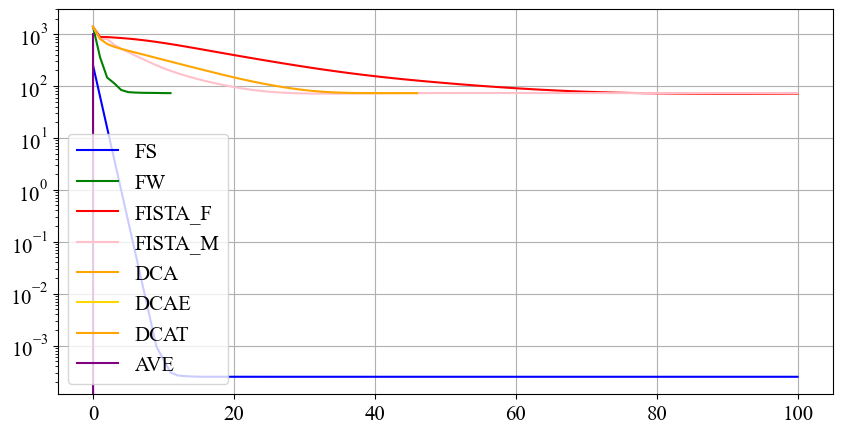

In [87]:
plt.figure(figsize=(10,5))
# plt.axis([0,5,0.01,100])
# plt.plot(Luca_merit, label='Luca', color='orange')
plt.plot([FS_model.Psi(xx) for xx in FS_x_list], label='FS', color='blue')
plt.plot([FS_model.Psi(xx) for xx in FW_x_list], label='FW', color='green')
plt.plot([FS_model.Psi(xx) for xx in FISTA_F_x_list], label='FISTA_F', color='red')
plt.plot([FS_model.Psi(xx) for xx in FISTA_M_x_list], label='FISTA_M', color='pink')
plt.plot([FS_model.Psi(xx) for xx in DCA_x_list], label='DCA', color='orange')
plt.plot([FS_model.Psi(xx) for xx in DCAE_x_list], label='DCAE', color='gold')
plt.plot([FS_model.Psi(xx) for xx in DCAT_x_list], label='DCAT', color='orange')
plt.plot([FS_model.Psi(xx) for xx in AVE_x_list], label='AVE', color='purple')
plt.yscale('log')
plt.grid()
plt.legend()

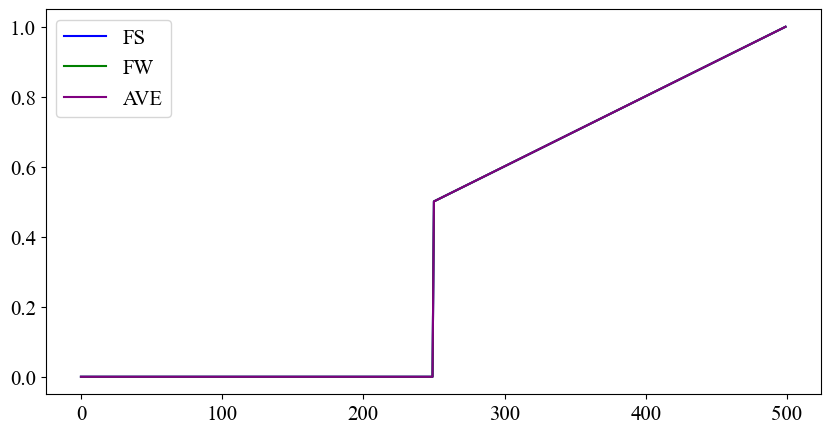

In [69]:
plt.figure(figsize=(10,5))
# plt.xticks(range(len(FS_x)), range(len(FS_x)))
# plt.plot(Luca_x, label='Luca', color='orange')
plt.plot(FS_x, label='FS', color='blue')
plt.plot(FW_x, label='FW', color='green')
# plt.plot(FISTA_F_x, label='FISTA_F', color='red')
# plt.plot(FISTA_M_x, label='FISTA_M', color='pink')
# plt.plot(DCAE_x, label='DCAE', color='gold')
# plt.plot(DCAT_x, label='DCAT', color='orange')
plt.plot(AVE_x, label='AVE', color='purple')
plt.legend()

In [70]:
# Check merit function value
# print('Luca Merit = \t', FS_model.Psi(Luca_x))
print('FS Merit = \t', FS_model.Psi(FS_x))
print('FW Merit = \t', FS_model.Psi(FW_x))
# print('FISTA_F Merit = \t', FS_model.Psi(FISTA_F_x))
# print('FISTA_M Merit = \t', FS_model.Psi(FISTA_M_x))
# print('DCAE Merit = \t', FS_model.Psi(DCAE_x))
# print('DCAT Merit = \t', FS_model.Psi(DCAT_x))
print('AVE Merit = \t', FS_model.Psi(AVE_x))

FS Merit = 	 1.1401505270772436e-30
FW Merit = 	 1.5074638860707772e-29
AVE Merit = 	 1.4422904167527132e-29


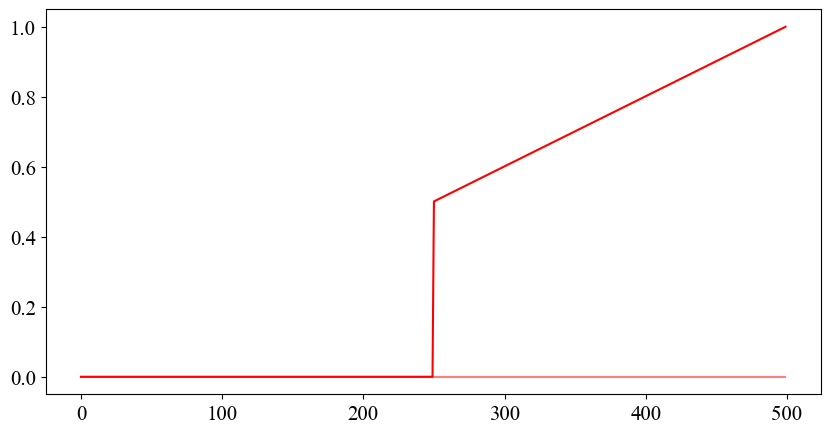

In [71]:
plt.figure(figsize=(10,5))

tr_list = AVE_x_list
NN = len(tr_list)
for i in range(NN):
    plt.plot(tr_list[i], color='red', alpha=(1/NN)+(1/NN)*i)

In [82]:
import cvxpy as cp

ModuleNotFoundError: No module named 'cvxpy'

In [2]:
cp.installed_solvers()

['CVXOPT',
 'ECOS',
 'ECOS_BB',
 'GLPK',
 'GLPK_MI',
 'GUROBI',
 'MOSEK',
 'OSQP',
 'SCS']

In [23]:
N = 1000
M, b = A6().coef(N)

In [24]:
def cp_sol(solver_name):
    x = cp.Variable(N)
    objective   = cp.Minimize(np.ones(N)@x)
    constraints = [M@x >= - b, x>=0]
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=solver_name)
    
    return True

In [37]:
%%time
model = gp.Model()
model.setParam('OutputFlag', 0) # Mute putput
model.setParam('Method', 1)

x = model.addMVar(N, lb=0.0)
    
model.setObjective(np.ones(N)@x)    
model.addConstr(M@x >= - b)
    

model.optimize()


Wall time: 324 ms


Changed value of parameter Method to 0
   Prev: -1  Min: -1  Max: 5  Default: -1


In [33]:
%%time
cp_sol(cp.GUROBI)

Wall time: 9.96 s


True

In [34]:
%%time
cp_sol(cp.ECOS)

Wall time: 8.44 s


True

In [35]:
%%time
cp_sol(cp.GLPK)

Wall time: 1.12 s


True

In [36]:
%%time
cp_sol(cp.SCS)

Wall time: 4.44 s


True

In [37]:
%%time
cp_sol(cp.GLPK_MI)

Wall time: 1min 4s


True